In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image
import keras
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import ELU, PReLU, LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
from scipy.ndimage import rotate
import glob
import random
import cv2
from random import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

In [ ]:
base_imagens = "Originais"

# base_imagens = "ref1/ED"
# base_imagens = "ref1/KL"
# base_imagens = "ref1/Renyi"
# base_imagens = "ref1/Li"
# base_imagens = "ref1/Perez-Bueno"
# base_imagens = "ref1/Tosta"
# base_imagens = "ref1/Vahadane"
#
# base_imagens = "ref2/ED" #png 
# base_imagens = "ref2/KL" #png
# base_imagens = "ref2/Renyi" #png
# base_imagens = "ref2/Li" #jpg
# base_imagens = "ref2/Perez-Bueno" #jpg
# base_imagens = "ref2/Tosta" #jpg
# base_imagens = "ref2/Vahadane" #jpg
#
# base_imagens = "ref3/ED"
# base_imagens = "ref3/KL"
# base_imagens = "ref3/Renyi"
# base_imagens = "ref3/Li"
# base_imagens = "ref3/Perez-Bueno"
# base_imagens = "ref3/Tosta"
# base_imagens = "ref3/Vahadane"


In [3]:
def image_read(files):
    #variables for collecting batches of inputs and outputs
    batch_x = []
    batch_y = []
    
    for f in files:
        #get the masks. Note that masks are png files
        if base_imagens == 'mendeley':
            mask = Image.open(f'../datasets/{f.replace("01-original", "02-mask")}').convert('L')
        elif base_imagens == 'OralEpitheliumDB':
            mask = Image.open(f'../datasets/OralEpitheliumDB/Gold_Standard_Images/{f}.png')
        elif base_imagens == 'pedro':
            mask = Image.open(f'../datasets/pedro/masks/{f}.png')
        elif 'pedro' in base_imagens:
            mask = Image.open(f'../datasets/pedro/masks/{f}.png')
        elif 'unifesp' in base_imagens or 'dali' in base_imagens:
            mask = Image.open(f"../datasets/{base_imagens.split('/')[0]}/mascaras/{f}.png")
        elif 'Adriano' in base_imagens:
            mask = Image.open(f"../datasets/Adriano/Mascaras/{'/'.join(f.split('/')[-2:])}.png")
        elif 'SNOW' in base_imagens:
            mask = Image.open(f"../datasets/{base_imagens}/mask/{f}.mat")
        
        if mask.size[0] == 512:
            mask = np.array(mask.resize((256, 256)))
        elif mask.size[0] == 1000:
            mask = np.array(mask.resize((1024, 1024)))
        elif mask.size[0] == 450:
            mask = np.array(mask.resize((512, 284)))
        elif mask.size[0] == 640:
            mask = np.array(mask.resize((768, 768)))
            # Extrair o canal alfa
            alpha_channel = mask[..., 3]

            # Manter a transparência como níveis de cinza
            gray_image = alpha_channel[..., np.newaxis]

            # Se necessário, converter para uma matriz com tipo de dado uint8
            mask = np.asarray(gray_image, dtype=np.uint8)
        else:
            mask = np.array(mask)
        
        if mask.shape[0] != 768:
            mask = np.expand_dims(mask, axis=-1)
        
        #preprocess the mask
        #print(mask)
        mask[mask < 127] = 0
        mask[mask >= 127] = 1
            
        # Carregar a imagem
        if base_imagens == 'mendeley':
            raw = Image.open(f'../datasets/{f}')
        elif base_imagens == 'OralEpitheliumDB':
            raw = Image.open(f'../datasets/OralEpitheliumDB/Original_ROI_Images/{f}.tif')
        elif base_imagens == 'pedro':
            raw = Image.open(f'../datasets/pedro/images/{f}.jpg')
        elif 'pedro' in base_imagens:
            raw = Image.open(f'../datasets/{base_imagens}/{f}.jpg')
        elif 'unifesp' in base_imagens or 'dali' in base_imagens:
            try:
                raw = Image.open(f'../datasets/{base_imagens}/{f}.png')
            except:
                try:
                    raw = Image.open(f'../datasets/{base_imagens}/{f}.jpg')
                except:
                    raw = Image.open(f'../datasets/{base_imagens}/{f}.tif')
        elif 'Adriano' in base_imagens:
            if 'Originais' in base_imagens:
                raw = Image.open(f'../datasets/{f}.tif')
            else:
                try:
                    raw = Image.open(f'../datasets/{f}.png')
                except:
                    try:
                        raw = Image.open(f'../datasets/{f}.jpg')
                    except:
                        raw = Image.open(f'../datasets/{f}.tif')
        elif 'SNOW' in base_imagens:
            raw = Image.open(f'../datasets/{base_imagens}/{f}.png')
        
        if raw.size[0] == 512:
            raw = np.array(raw.resize((256, 256)))
        elif raw.size[0] == 1000:
            raw = np.array(raw.resize((1024, 1024)))
        elif raw.size[0] == 640:
            raw = np.array(raw.resize((768, 768)))
        elif raw.size[0] == 450:
            raw = np.array(raw.resize((512, 284)))
        else:
            raw = np.array(raw)
        
        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]
        
        #if raw.shape[0] != 461:
        #    print("mask", mask.shape)
        #    print("raw", raw.shape)
        
        sz = 256
        for x in range(0, raw.shape[0]-1, sz):
            for y in range(0, raw.shape[1]-1, sz):
                img =  raw[x:x+sz, y:y+sz]
                msk = mask[x:x+sz, y:y+sz]
                
                if img.shape[0] == sz and img.shape[1] == sz:
                    #print(raw.shape, (x, y), img.shape, msk.shape)
                    
                    batch_x.append(img)
                    batch_y.append(msk)
        
        #batch_x.append(raw)
        #batch_y.append(mask)

    #preprocess a batch of images and masks
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    #batch_y = np.expand_dims(batch_y,3)

    return (batch_x, batch_y)

In [4]:
import os

all_files = []

if base_imagens == 'mendeley':
    all_files += ['mendeley/training/tumor/patch/640x640/1009009/01-roi/01-original/' + string for string in os.listdir('../datasets/mendeley/training/tumor/patch/640x640/1009009/01-roi/01-original')]
    all_files += ['mendeley/training/tumor/patch/640x640/1009010x1000902/01-roi/01-original/' + string for string in os.listdir('../datasets/mendeley/training/tumor/patch/640x640/1009010x1000902/01-roi/01-original')]
    all_files += ['mendeley/training/tumor/patch/640x640/1009011/01-roi/01-original/' + string for string in os.listdir('../datasets/mendeley/training/tumor/patch/640x640/1009011/01-roi/01-original')]
    all_files += ['mendeley/training/tumor/patch/640x640/1009014/01-roi/01-original/' + string for string in os.listdir('../datasets/mendeley/training/tumor/patch/640x640/1009014/01-roi/01-original')]
    all_files += ['mendeley/training/tumor/patch/640x640/1009016x1000903/01-roi/01-original/' + string for string in os.listdir('../datasets/mendeley/training/tumor/patch/640x640/1009016x1000903/01-roi/01-original')]
    all_files += ['mendeley/training/tumor/patch/640x640/1009017/01-roi/01-original/' + string for string in os.listdir('../datasets/mendeley/training/tumor/patch/640x640/1009017/01-roi/01-original')]
    all_files += ['mendeley/training/tumor/patch/640x640/1009023/01-roi/01-original/' + string for string in os.listdir('../datasets/mendeley/training/tumor/patch/640x640/1009023/01-roi/01-original')]

    all_files += ['mendeley/testing/tumor/patch/640x640/1009009/01-roi/01-original/' + string for string in os.listdir('../datasets/mendeley/testing/tumor/patch/640x640/1009009/01-roi/01-original')]
    all_files += ['mendeley/testing/tumor/patch/640x640/1009010x1000902/01-roi/01-original/' + string for string in os.listdir('../datasets/mendeley/testing/tumor/patch/640x640/1009010x1000902/01-roi/01-original')]
    all_files += ['mendeley/testing/tumor/patch/640x640/1009011/01-roi/01-original/' + string for string in os.listdir('../datasets/mendeley/testing/tumor/patch/640x640/1009011/01-roi/01-original')]
    all_files += ['mendeley/testing/tumor/patch/640x640/1009014/01-roi/01-original/' + string for string in os.listdir('../datasets/mendeley/testing/tumor/patch/640x640/1009014/01-roi/01-original')]
    all_files += ['mendeley/testing/tumor/patch/640x640/1009016x1000903/01-roi/01-original/' + string for string in os.listdir('../datasets/mendeley/testing/tumor/patch/640x640/1009016x1000903/01-roi/01-original')]
    all_files += ['mendeley/testing/tumor/patch/640x640/1009023/01-roi/01-original/' + string for string in os.listdir('../datasets/mendeley/testing/tumor/patch/640x640/1009023/01-roi/01-original')]
elif base_imagens == 'OralEpitheliumDB':
    all_files += ['healthy/' + string.split(".")[0] for string in os.listdir('../datasets/OralEpitheliumDB/Original_ROI_Images/healthy')]
    all_files += ['mild/' + string.split(".")[0] for string in os.listdir('../datasets/OralEpitheliumDB/Original_ROI_Images/mild')]
    all_files += ['moderate/' + string.split(".")[0] for string in os.listdir('../datasets/OralEpitheliumDB/Original_ROI_Images/moderate')]
    all_files += ['severe/' + string.split(".")[0] for string in os.listdir('../datasets/OralEpitheliumDB/Original_ROI_Images/severe')]
elif base_imagens == 'pedro':
    files_dir1 = set(os.path.splitext(file)[0] for file in os.listdir('../datasets/pedro/images'))
    files_dir2 = set(os.path.splitext(file)[0] for file in os.listdir('../datasets/pedro/masks'))
    
    # Interseção de arquivos sem a última extensão
    common_files = files_dir1.intersection(files_dir2)
    all_files = list(common_files)
    #all_files += ['.'.join(string.split(".")[:-1]) for string in os.listdir('../datasets/pedro/images')]
elif 'unifesp' in base_imagens or 'dali' in base_imagens:
    files_dir1 = set(os.path.splitext(file)[0] for file in os.listdir(f'../datasets/{base_imagens}'))
    files_dir2 = set(os.path.splitext(file)[0] for file in os.listdir(f'../datasets/{base_imagens.split("/")[0]}/mascaras'))
    
    # Interseção de arquivos sem a última extensão
    common_files = files_dir1.intersection(files_dir2)
    all_files = list(common_files)
    
elif 'Adriano' in base_imagens:
    all_files += [f'{base_imagens}/healthy/' + string.split(".")[0] for string in os.listdir(f'../datasets/{base_imagens}/healthy')]
    all_files += [f'{base_imagens}/mild/' + string.split(".")[0] for string in os.listdir(f'../datasets/{base_imagens}/mild')]
    all_files += [f'{base_imagens}/moderate/' + string.split(".")[0] for string in os.listdir(f'../datasets/{base_imagens}/moderate')]
    all_files += [f'{base_imagens}/severe/' + string.split(".")[0] for string in os.listdir(f'../datasets/{base_imagens}/severe')]
    
elif 'SNOW' in base_imagens:
    files_dir1 = set(os.path.splitext(file)[0] for file in os.listdir('../datasets/SNOW/image'))
    files_dir2 = set(os.path.splitext(file)[0] for file in os.listdir('../datasets/SNOW/mask'))
    
    # Interseção de arquivos sem a última extensão
    common_files = files_dir1.intersection(files_dir2)
    all_files = list(common_files)


train_split = int(0.7 * len(all_files))
val_split = int(0.8 * len(all_files))

train_files = all_files[0:train_split]
val_files  = all_files[train_split:val_split]
test_files  = all_files[val_split:]

print("Imagens Treinamento:", len(train_files))
print("Imagens Validação:", len(val_files))
print("Imagens Teste:", len(test_files))


train_img_generator = image_read(train_files)
val_img_generator = image_read(val_files)
test_img_generator = image_read(test_files)

Imagens Treinamento: 463
Imagens Validação: 66
Imagens Teste: 133


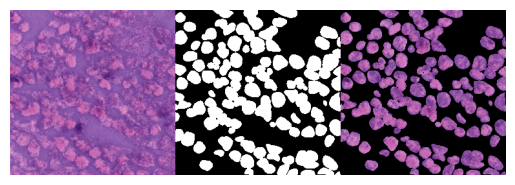

In [5]:
x_train, y_train = train_img_generator
x_test, y_test = test_img_generator
x_val, y_val = val_img_generator

plt.axis('off')

img = x_train[1]
msk = y_train[1].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

In [6]:
#mask = Image.open(f'../datasets/{base_imagens}/Mascaras/{train_files[1]}.png')
#mask = np.array(mask.resize((450, 250)))
#mask = np.expand_dims(mask, axis=-1)
#mask[mask > 0] = 1
#
#image = Image.open(f'../datasets/{base_imagens}/{train_files[1]}.tif')
#image = np.array(image.resize((450, 250)))
#
#if len(image.shape) == 2:
#  image = np.stack((image,)*3, axis=-1)
#else:
#  image = image[:,:,0:3]
#
#
#imgs = []
#msks = []
#sz = 256
#for x in range(0, image.shape[0]-1, sz):
#    for y in range(0, image.shape[1]-1, sz):
#        img =  image[x:x+sz, y:y+sz]
#        msk = mask[x:x+sz, y:y+sz]
#        print(image.shape, (x, y), img.shape, msk.shape)
#        if img.shape[0] == sz and img.shape[1] == sz:
#
#            imgs.append(img)
#            msks.append(msk)
#
#img = image #imgs[0]
#msk = mask.squeeze() #msks[0].squeeze()
#msk = np.stack((msk,)*3, axis=-1)
#
#plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))
##plt.imshow( np.concatenate(msk, axis = 1))

In [7]:
print(len(val_files))
print(len(x_val))
print(y_train.shape)

66
66
(463, 256, 256, 1)


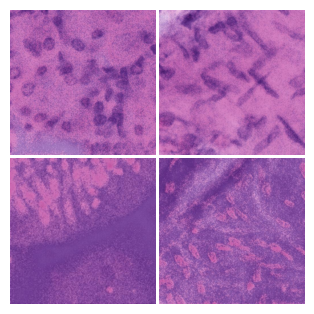

In [8]:
fig = plt.figure(figsize=(3, 3))

offset = 0

#mostra os crops gerados pela primeira imagem
for i in range(1, 5):
    fig.add_subplot(2, 2, i)
    plt.imshow(x_val[(i + offset) - 1])
    plt.axis('off')
    fig.tight_layout(pad=0.2)

In [9]:
saida_img = f"../datasets/crop_{base_imagens}/train"
saida_msk = f"../datasets/crop_{base_imagens}/train/mascaras"

if os.path.exists(saida_img):
    shutil.rmtree(saida_img)
    
if os.path.exists(saida_msk):
    shutil.rmtree(saida_msk)

if not os.path.exists(saida_img):
    os.makedirs(saida_img)
    
if not os.path.exists(saida_msk):
    os.makedirs(saida_msk)

for j in range(len(x_train)):
    path_img = os.path.join(saida_img, f"{j}.png")
    path_msk = os.path.join(saida_msk, f"{j}.png")

    save_img(path_img, x_train[j])
    save_img(path_msk, y_train[j])

In [10]:
saida_img = f"../datasets/crop_{base_imagens}/val"
saida_msk = f"../datasets/crop_{base_imagens}/val/mascaras"

if os.path.exists(saida_img):
    shutil.rmtree(saida_img)
    
if os.path.exists(saida_msk):
    shutil.rmtree(saida_msk)

if not os.path.exists(saida_img):
    os.makedirs(saida_img)
    
if not os.path.exists(saida_msk):
    os.makedirs(saida_msk)

for j in range(len(x_val)):
    path_img = os.path.join(saida_img, f"{j}.png")
    path_msk = os.path.join(saida_msk, f"{j}.png")

    save_img(path_img, x_val[j])
    save_img(path_msk, y_val[j])

In [11]:
saida_img = f"../datasets/crop_{base_imagens}/test"
saida_msk = f"../datasets/crop_{base_imagens}/test/mascaras"

if os.path.exists(saida_img):
    shutil.rmtree(saida_img)                                            
if os.path.exists(saida_msk):
    shutil.rmtree(saida_msk)

if not os.path.exists(saida_img):
    os.makedirs(saida_img)
    
if not os.path.exists(saida_msk):
    os.makedirs(saida_msk)

for j in range(len(x_test)):
    path_img = os.path.join(saida_img, f"{j}.png")
    path_msk = os.path.join(saida_msk, f"{j}.png")

    save_img(path_img, x_test[j])
    save_img(path_msk, y_test[j])